<a href="https://colab.research.google.com/github/ecordeiro/cefet/blob/main/NSGA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [79]:
def plot_scatter_with_line_sea(populacao, x_title='X', y_title='Y', title='Scatter Plot with Connected Points'):
    # Extract points from population
    points = [(ind.fitness[0], ind.fitness[1]) for ind in populacao if ind.domination_count == 0]

    # Unzip points into separate lists for x and y
    x_values, y_values = zip(*points)

    # Create scatter plot
    sns.scatterplot(x=x_values, y=y_values, label='Scatter Plot')

    # Create line plot
    sns.lineplot(x=x_values, y=y_values, color='red', linewidth=2, label='Connected Line')

    # Add title and labels
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)

    # Display the plot
    plt.show()

# Example usage:
# plot_scatter_with_line_sea(populacao)

In [75]:
class Individual:
    def __init__(self, chromosome_length, limites):
        # Inicializa um indivíduo com um cromossomo aleatório
        self.fitness = None
        self.dominated_solutions = []  # Soluções dominadas por este indivíduo
        self.domination_count = 0  # Contagem de quantos indivíduos dominam este indivíduo
        self.limite_inferior, self.limite_superior = limites
        self.chromosome = [np.random.uniform(self.limite_inferior,self.limite_superior) for _ in range(chromosome_length)]
        self.crowding_distance = 0

In [76]:
def f1(ind):
    n = len(ind.chromosome)
    valor = sum([(elemento**2 - 4) - 10 * np.cos(2 * np.pi * (elemento**2 - 4)) for elemento in ind.chromosome])
    return 10 * n + valor

def f2(ind):
    n = len(ind.chromosome)
    valor = sum([(elemento**2 - 10 * np.cos(2 * np.pi * elemento)) for elemento in ind.chromosome])
    return 10 * n + valor

def gerar_populacao(population_size,chromosome_length,limites):
    # population_size = 50
    # chromosome_length = 2
    # limites = (-5.12, 5.12)
    populacao = [Individual(chromosome_length, limites) for _ in range(population_size)]

    for p in populacao:
        p.fitness = [f1(p),f2(p)]

    return populacao

def crowding_distance_assignment(population):
    # Zera as listas de soluções dominadas e contagens de dominação
    for ind in population:
        ind.dominated_solutions = []

    # Calcula as soluções dominadas e atualiza a contagem de dominação para cada indivíduo
    for i in range(len(population)):
        for j in range(i + 1, len(population)):
            if dominates(population[i].fitness, population[j].fitness):
                population[j].dominated_solutions.append(i)
                population[i].domination_count += 1
            elif dominates(population[j].fitness, population[i].fitness):
                population[i].dominated_solutions.append(j)
                population[j].domination_count += 1

    # Calcula a distância de multidão de cada indivíduo
    for ind in population:
        ind.crowding_distance = 0

    num_objectives = len(population[0].fitness)
    # Calcula a distância de multidão para cada objetivo
    for m in range(num_objectives):
        population.sort(key=lambda x: x.fitness[m])
        population[0].crowding_distance = float('inf')
        population[-1].crowding_distance = float('inf')
        for i in range(1, len(population) - 1):
            population[i].crowding_distance += (population[i + 1].fitness[m] - population[i - 1].fitness[m])

def dominates(fitness1, fitness2):
    # Verifica se fitness1 domina fitness2
    return all(fitness1[i] <= fitness2[i] for i in range(len(fitness1))) and any(fitness1[i] < fitness2[i] for i in range(len(fitness1)))

def nsga2(population, num_generations, tournament_size, crossover_rate, mutation_rate, limites):
    # Executa o algoritmo NSGA-II para um número fixo de gerações
    for _ in range(num_generations):
        offspring = []
        # Cria a nova população de descendentes
        while len(offspring) < len(population):
            parent1 = tournament_selection(population, tournament_size)
            parent2 = tournament_selection(population, tournament_size)
            child1, child2 = crossover(parent1, parent2, crossover_rate, limites)
            offspring.extend(mutate(child1, mutation_rate, limites))
            offspring.extend(mutate(child2, mutation_rate, limites))
        population.extend(offspring)
        crowding_distance_assignment(population)
        population.sort(key=lambda x: (x.domination_count, -x.crowding_distance))
        population = population[:len(population) // 2]  # Seleciona os melhores indivíduos

def tournament_selection(population, size):
    # Seleciona um indivíduo do torneio
    tournament = random.sample(population, size)
    tournament.sort(key=lambda x: (x.domination_count, -x.crowding_distance))
    return tournament[0]

def crossover(parent1, parent2, rate, limites):
    # Executa o crossover entre dois pais com uma determinada taxa de crossover
    if random.random() < rate:
        point = random.randint(1, len(parent1.chromosome) - 1)
        child1 = Individual(len(parent1.chromosome),limites)
        child2 = Individual(len(parent2.chromosome),limites)
        child1.chromosome = parent1.chromosome[:point] + parent2.chromosome[point:]
        child2.chromosome = parent2.chromosome[:point] + parent1.chromosome[point:]
        child1.fitness = [f1(child1),f2(child1)]
        child2.fitness = [f1(child2),f2(child2)]
        return child1, child2
    else:
        return parent1, parent2


def mutate(individual, rate, limites):
    # Realiza a mutação em um indivíduo com uma determinada taxa de mutação
    mutated_individuals = []
    for i in range(len(individual.chromosome)):
        if random.random() < rate:
            mutated_individual = Individual(len(individual.chromosome),limites)
            mutated_individual.chromosome = individual.chromosome[:]
            mutated_individual.chromosome[i] = random.random()
            mutated_individual.fitness = [f1(mutated_individual),f2(mutated_individual)]
            mutated_individuals.append(mutated_individual)
    return mutated_individuals



In [83]:
tamanho_cromossomos = 2

for i in range(0, 10):

    # Exemplo de uso
    qtd_individuos = 200
    tamanho_cromossomos = 2
    num_generations = 55
    tournament_size = 10
    crossover_rate = 0.8
    mutation_rate = 0.01
    limites = (-5.12, 5.12)

    populacao = gerar_populacao(qtd_individuos,tamanho_cromossomos,limites)

    nsga2(populacao, num_generations, tournament_size, crossover_rate, mutation_rate,limites)

    # Após a execução do NSGA-II, você pode acessar as soluções não dominadas da população
    non_dominated_solutions = [ind for ind in populacao if ind.domination_count == 0]
    #print("Número de soluções não dominadas:", len(non_dominated_solutions))

    print(f"Solução {i} para {num_generations} gerações e n={tamanho_cromossomos}.", f"Pontos não dominados: {len(non_dominated_solutions)}")

    #plot_scatter_with_line(populacao)
    plot_scatter_with_line_sea(populacao)

Número de soluções não dominadas: 5


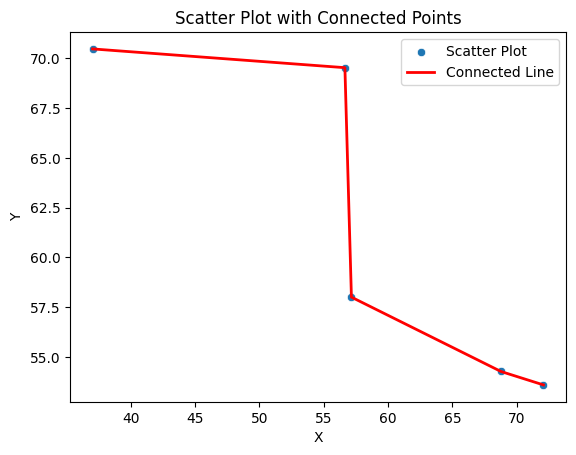

In [84]:
plot_scatter_with_line_sea(populacao)
